# http://earthpy.org/smos_sea_ice_thickness.html

# Reading and processing Envisat ASAR

In [2]:
from multiprocessing import cpu_count
numProcs = cpu_count()

In [3]:
import datetime

import epr
reload(epr)

# import numpy.polynomial.polynomial as pl
import matplotlib.pyplot as plt
from numpy import row_stack, asarray, double, fliplr, delete, sin, pi, exp, log, log10
# from numpy import meshgrid

In [4]:
fileNameList = [
            'ASA_WSM_1PNPDE20110523_084634_000000983102_00395_48254_2349.N1',
            'ASA_WSM_1PNPDE20111127_085336_000002143109_00079_50955_3727.N1',
            'ASA_WSM_1PNPDK20111216_202156_000002693109_00359_51235_5447.N1',
            'ASA_WSM_1PNPDK20111227_085404_000002453110_00079_51386_9192.N1',
            'ASA_WSM_1PNPDK20120105_194838_000002693110_00215_51522_2440.N1',
            'ASA_WSM_1PNPDK20120108_193839_000002693110_00258_51565_3503.N1',
            'ASA_WSM_1PNPDK20120113_195518_000002693110_00330_51637_5211.N1',

            'ASA_WSM_1PNPDK20100921_194247_000001772093_00114_44757_1367.N1',
            'ASA_WSM_1PNPDK20100927_195408_000000862093_00200_44843_3688.N1',
            
            'ASA_WSM_1PNPDE20110815_090644_000001903105_00309_49461_8731.N1'
            ]

fileName = fileNameList[-2]

# YellowSea - 3413 Doesn't work correctly
# fileName = 'ASA_IMM_1PNPDE20080202_021339_000000812065_00361_30976_3972.N1'
# fileName = 'ASA_WSM_1PNPDK20120320_135328_000000923112_00427_52596_1286.N1'

# Baikal - same thing
# fileName = 'ASA_WSM_1PNPDE20100912_025847_000000922092_00476_44618_1878.N1'

# Kuroshio - also cropping is not correct enough
# fileName = 'ASA_WSM_1PNPDK20120108_125143_000000923110_00254_51561_3395.N1'

# Laptev - awful cropping in 3413 around 150E
# (134.73301433365424, 158.69928524693626) (67.91966824291822, 78.468371541120206)
# fileName = 'ASA_WSM_1PNPDE20120303_110522_000001773112_00181_52350_7967.N1'

# Looks like the problem is with lons around 110-140 East
# http://epsg.io/3413 notes that the EPSG3413 is a Cartesian 2D CS for north polar azimuthal lonO 45°W.
# Axes: X,Y. Orientations: X along 45°E, Y along 135°E meridians. UoM: m.
# That could be the case!!!! Y along 135°E meridians!!!!!!
# In any case this coordinate system is used for above 60°N only!!!!
# YES looks like that this was the case, for 3413 lat_0=90 and lon_0=-45
# SO THE PROJ DOESN'T SEE some parts of the image
# If you specify lat_0/lon_0 for the center of the image everything works great
#         lat_0 = (up + down) / 2
#         lon_0 = (right + left) / 2
# But that wouldn't be 3413 anymore :)

# Gibraltar - 3413 OK!
# fileName = 'ASA_WSM_1PNPDE20120405_222713_000000923113_00231_52831_0092.N1'

# Agulhas - 3413 OK!
# fileName = 'ASA_WSM_1PNPDE20120311_204437_000000733112_00301_52470_1138.N1'

# BlackSea - 3413 OK!
# fileName = 'ASA_WSM_1PNPDE20120402_191831_000000923113_00186_52786_8976.N1'

# Svalbard
# fileName = 'ASA_WSM_1PNPDK20100920_102202_000001162093_00094_44737_0804.N1'

# for Ania
fileName = 'ASA_WSM_1PNPDE20101006_084238_000002692093_00322_44965_8292.N1'


fileName = 'ASA_IMM_1PNPDE20080202_021339_000000812065_00361_30976_3972.N1'

dt = datetime.datetime.strptime(fileName[14:22], '%Y%m%d').timetuple()

year = str(dt.tm_year)
day = str(dt.tm_yday)

if len(day) == 1:
    day = '00' + day
elif len(day) == 2:
    day = '0' + day

iPath = '/media/SOLabNFS2/store/satellite/asar/' + year + '/' + day + '/'
# oPath = '/media/SOLabNFS2/tmp/roughness/'
oPath = '/home/mag/'

product = epr.Product(iPath + fileName)

In [5]:
# print product.get_band_names()
# print product.get_dataset_names()
# dataset = product.get_dataset('GEOLOCATION_GRID_ADS')
# record = dataset.read_record(12)
# record.get_field_names()[:30]

# field = record.get_field('line_num')
# print field
# field = record.get_field('num_lines')
# print field
# field = record.get_field('first_line_tie_points.samp_numbers')
# print field

## Reading product raw_counts, lats/lons and incident angles

In [6]:
band = product.get_band('proc_data')

sc_w = product.get_scene_width()
sc_h = product.get_scene_height()

raw_counts = band.read_as_array(sc_w, sc_h)#, xoffset=100, yoffset=6500, xstep=2, ystep=2)
# lat and lon are incorrect!
# lat = product.get_band('latitude').read_as_array()
# lon = product.get_band('longitude').read_as_array()
incident_angle = product.get_band('incident_angle').read_as_array()

In [7]:
dataset = product.get_dataset('GEOLOCATION_GRID_ADS')

In [8]:
# Get lat/lon from geolocation grid
fltp_lats = map(lambda x: \
               dataset.read_record(x).get_field('first_line_tie_points.lats').get_elems(), \
               range(dataset.get_num_records()))
lltp_lats = map(lambda x: \
               dataset.read_record(x).get_field('last_line_tie_points.lats').get_elems(), \
               range(dataset.get_num_records()))
fltp_lons = map(lambda x: \
               dataset.read_record(x).get_field('first_line_tie_points.longs').get_elems(), \
               range(dataset.get_num_records()))
lltp_lons = map(lambda x: \
               dataset.read_record(x).get_field('last_line_tie_points.longs').get_elems(), \
               range(dataset.get_num_records()))

fltp_lats = asarray(double(fltp_lats))/1e6
lltp_lats = asarray(double(lltp_lats))/1e6
fltp_lons = asarray(double(fltp_lons))/1e6
lltp_lons = asarray(double(lltp_lons))/1e6

lats = row_stack((fltp_lats, lltp_lats[-1,:]))
lons = row_stack((fltp_lons, lltp_lons[-1,:]))

In [9]:
from scipy.interpolate import RectBivariateSpline
from numpy import linspace, arange

def imresize(image, size):
    """
    Resizes coefficient arrays using bivariate spline approximation.
    """
    m, n = image.shape
    X = linspace(0, m - 1, size[0])
    Y = linspace(0, n - 1, size[1])
    kx, ky = min([m - 1, 3]), min([n - 1, 3])
    interp = RectBivariateSpline(
        arange(m), arange(n), image, kx=kx, ky=ky)
    resized = interp(X, Y)
    return resized

In [10]:
lats = fliplr(lats)
lons = fliplr(lons)

lats_2 = imresize(lats, raw_counts.shape)
lons_2 = imresize(lons, raw_counts.shape)

In [11]:
print lats.min(), lats_2.min()
print lats.max(), lats_2.max()
print lons.min(), lons_2.min()
print lons.max(), lons_2.max()
print lats.shape, lats_2.shape
print lats_2.shape[1]/lats.shape[1]

36.884452 36.884452
41.916864 41.916864
119.487065 119.487065
122.130979 122.130979
(55, 11) (7290, 1504)
136


In [12]:
raw_counts_trmmd = raw_counts
# Trimming the array by removing zero values from side rows and cols
msk = []
for m in range(raw_counts_trmmd.shape[0]):
    if raw_counts_trmmd[m,:].sum()==0:
        msk.append(m)
raw_counts_trmmd = delete(raw_counts_trmmd,msk,axis=0)
lats_2 =  delete(lats_2,msk,axis=0)
lons_2 =  delete(lons_2,msk,axis=0)
incident_angle = delete(incident_angle,msk,axis=0)

msk = []
for n in range(raw_counts_trmmd.shape[1]):
    if raw_counts_trmmd[:,n].sum()==0:
        msk.append(n)
raw_counts_trmmd = delete(raw_counts_trmmd,msk,axis=1)
lats_2 =  delete(lats_2,msk,axis=1)
lons_2 =  delete(lons_2,msk,axis=1)
incident_angle = delete(incident_angle,msk,axis=1)
raw_counts = raw_counts_trmmd

In [13]:
# Masking Land

# https://github.com/tkrajina/srtm.py

# http://glcf.umd.edu/data/watermask/

# http://pycoast.googlecode.com/git/docs/build/html/index.html
# http://blogg.uit.no/thk031/2013/05/04/rasterizing-a-land-mask-for-an-unprojected-satellite-image/
# http://www.soest.hawaii.edu/pwessel/gshhs/index.html



## Adding Sigma_0

In [14]:
# dataset = product.get_dataset('MAIN_PROCESSING_PARAMS_ADS')
# record = dataset.read_record(0)
# record.get_field_names()[:30]

# field = record.get_field('calibration_factors.1.proc_scaling_fact')
# print field
# field = record.get_field('calibration_factors.1.ext_cal_fact')
# print field
# field = record.get_field('calibration_factors.2.proc_scaling_fact')
# print field
# field = record.get_field('calibration_factors.2.ext_cal_fact')
# print field

In [26]:
calibration_constant = \
product.get_dataset('MAIN_PROCESSING_PARAMS_ADS').read_record(0).get_field('calibration_factors.1.ext_cal_fact').get_elems()
# sigma0 = 10*log10( raw_counts_trmmd**2*sin(incident_angle*pi/180)/calibration_constant )
sigma0 = raw_counts_trmmd**2*sin(incident_angle*pi/180)/calibration_constant

# normalizing sigma0 for water
# range_water = (sin(incident_angle*pi/180)**4)/(sin(31*pi/180)**4)
# sigma0w = ( raw_counts_trmmd**2*sin(incident_angle*pi/180)*range_water/calibration_constant )

## NICE image (roughness)

In [21]:
from scipy.signal import wiener
# sigma0w = wiener(sigma0, mysize=(3,3), noise=None)
# Lee-Wiener filtering blures to much the ASAR scenes, so we use it only for wind field
sigma0w = sigma0

In [22]:
pol = product.get_sph().get_field('MDS1_TX_RX_POLAR').get_elem()
if pol == 'H/H':
    ph = (2.20495, -14.3561e-2, 11.28e-4)
    sigma0_hh_ref = exp( ( ph[0]+incident_angle*ph[1]+incident_angle**2*ph[2])*log(10) )
    roughness = sigma0w/sigma0_hh_ref
elif pol == 'V/V':
    pv = (2.29373, -15.393e-2, 15.1762e-4)
    sigma0_vv_ref = exp( ( pv[0]+incident_angle*pv[1]+incident_angle**2*pv[2])*log(10) )
    roughness = sigma0w/sigma0_vv_ref

In [27]:
scale = 1

plt.close('all')
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(10*log10(sigma0[::scale,::scale]), vmin=-20, vmax=0)
plt.gray()
plt.colorbar()
plt.subplot(132)
plt.imshow(10*log10(sigma0w[::scale,::scale]), vmin=-20, vmax=0)
plt.gray()
plt.colorbar()
plt.subplot(133)
plt.imshow(roughness[::scale,::scale], vmin=0, vmax=2)
plt.gray()
plt.colorbar()
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10


In [24]:
plt.close('all')
plt.figure(figsize=(16,12))
plt.imshow(raw_counts[::scale,::scale])
plt.gray()
plt.colorbar()
plt.show()

In [25]:
plt.close('all')
plt.figure(figsize=(24,10))
plt.subplot(131)
plt.imshow(10*log10(sigma0[::scale,::scale]), vmin=-20, vmax=0)
plt.gray()
plt.colorbar()
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


## Adding Model wind

In [19]:
from math import atan

def windDirection(u, v):
    U = u.ravel()
    V = v.ravel()
    direction = zeros(size(U))
    for i in range(0, len(U)):
        if U[i] >= 0 and V[i] > 0: direction[i] = ((180 / pi) * atan(abs(U[i] / V[i])) + 180)
        if U[i] < 0 and V[i] > 0: direction[i] = (-(180 / pi) * atan(abs(U[i] / V[i])) + 180)
        if U[i] >= 0 and V[i] < 0: direction[i] = (-(180 / pi) * atan(abs(U[i] / V[i])) + 360)
        if U[i] < 0 and V[i] < 0: direction[i] = ((180 / pi) * atan(abs(U[i] / V[i])))
        if V[i] == 0 and U[i] > 0: direction[i] = 270
        if V[i] == 0 and U[i] < 0: direction[i] = 90
        if V[i] == 0 and U[i] == 0: direction[i] = 0
    return reshape(direction, v.shape)

In [20]:
# Using NCEP
from createMapsEtopo1 import findSubsetIndices
import pygrib

def ncepGFSmodel(startTime, lats_2, lons_2):
    """
    NCEP GFS model wind for givven time, lat/lon crop 
    """
    ncepGFSmodel = {} # empty dict for ncepGFSmodel

    iPath_wind = '/media/SOLabNFS2/store/model/ncep/gfs/'

    # find the ncep gfs filename to open from ASAR filename
    baseHour = floor((startTime.hour+3/2)/6)*6
    baseHour = min(18, baseHour)
    if startTime.hour-baseHour>1.5:
        forecastHour = 3
    else:
        forecastHour = 0

    if startTime <= datetime.datetime(2014, 8, 19):
        ncepFileName = 'gfs' + startTime.strftime("%Y%m%d") + '/gfs.t' + '%.2d' %(baseHour) + 'z.master.grbf' + '%.2d' %(forecastHour)

        grbs = pygrib.open(iPath_wind + ncepFileName)

        u_wind = None
        v_wind = None

        # wind contains u=u_wind.values[:], Lats=u_wind.latlons()[0], Lons=u_wind.latlons()[1]
        for idx, msg_info in enumerate(grbs.select()):
            if msg_info['short_name'] == '10u':
                u_wind = grbs.message(idx + 1)
            elif msg_info['short_name'] == '10v':
                v_wind = grbs.message(idx + 1)

        u = u_wind.values[:]
        v = v_wind.values[:]
        lats_wind = u_wind.latlons()[0]
        lons_wind = u_wind.latlons()[1]
    else:
        ncepFileName = 'gfs.' + startTime.strftime("%Y%m%d") + '%.2d' %(baseHour) + '/gfs.t' + '%.2d' %(baseHour) + 'z.master.grbf' + '%.2d' %(forecastHour) + '.10m.uv.grib2'

        grbs = pygrib.open(iPath_wind + ncepFileName)

        u_wind = grbs.message(1)
        v_wind = grbs.message(2)
        u = u_wind['values']
        v = v_wind['values']
        lats_wind = u_wind['latitudes']
        lons_wind = u_wind['longitudes']
        lons_wind = reshape(lons_wind, (lons_wind.shape[0]/720, 720))
        lats_wind = reshape(lats_wind, (lats_wind.shape[0]/720, 720))


    #Make sure the longitude is between -180.00 .. 179.9
    lons_wind = map(lambda x : (lons_wind.ravel()[x]+180)-int((lons_wind.ravel()[x]+180)/360)*360-180, range(0,lons_wind.size))
    lons_wind = reshape(lons_wind, lats_wind.shape)
    # plt.close('all')
    # plt.imshow(lons_wind)
    # plt.colorbar()

#     #Make sure the latitudes is between -90.00 .. 89.9, starting from North - positive
#     lats_wind = map(lambda x : (lats_wind.ravel()[x]+90)-int((lats_wind.ravel()[x]+90)/180)*180-90, xrange(0,lats_wind.size))
#     lats_wind = reshape(lats_wind, lons_wind.shape)
#     if lats_wind[0,0] < lats_wind[-1,-1]:
#         lats_wind = flipud(lats_wind)
#         u = flipud(u)
#         v = flipud(v)
#     plt.close('all')
#     plt.imshow(lats_wind)
#     plt.colorbar()


    # find subset
    res = findSubsetIndices(lats_2.min(),lats_2.max(),lons_2.min(),lons_2.max(),lats_wind[:,0],lons_wind[0,:])
    # expand subset by 1 pixel for better further pyresample
    res[0]=res[0]-1
    res[1]=res[1]+1
    res[2]=res[2]-1
    res[3]=res[3]+1

    # crop the data
    u = u[int(res[2]):int(res[3]),int(res[0]):int(res[1])]
    v = v[int(res[2]):int(res[3]),int(res[0]):int(res[1])]
    ncepGFSmodel['lats_wind'] = lats_wind[int(res[2]):int(res[3]),int(res[0]):int(res[1])]
    ncepGFSmodel['lons_wind'] = lons_wind[int(res[2]):int(res[3]),int(res[0]):int(res[1])]

#     ncepGFSmodel['lats_wind'] = lats_wind
#     ncepGFSmodel['lons_wind'] = lons_wind

    ncepGFSmodel['wind_dir'] = windDirection(u,v)
    ncepGFSmodel['wind_speed'] = sqrt(u**2 + v**2)

#     del u_wind, v_wind
    return ncepGFSmodel

In [21]:
# Adding Model wind

startTime = datetime.datetime.strptime(fileName[14:29],"%Y%m%d_%H%M%S")

ncepGFSmodelWind = ncepGFSmodel(startTime, lats_2, lons_2)

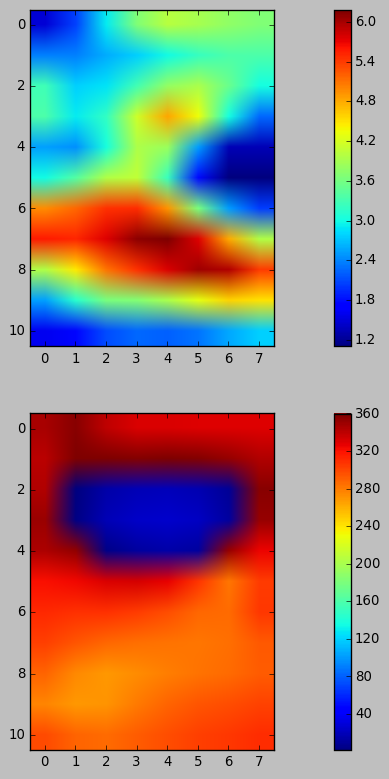

In [22]:
plt.close('all')
plt.figure(figsize=(16,2*double(sigma0w.shape[0])/double(sigma0w.shape[1])))
plt.subplot(211)
plt.imshow(ncepGFSmodelWind['wind_speed'])
plt.jet()
plt.colorbar()
plt.subplot(212)
plt.imshow(ncepGFSmodelWind['wind_dir'])
plt.jet()
plt.colorbar()


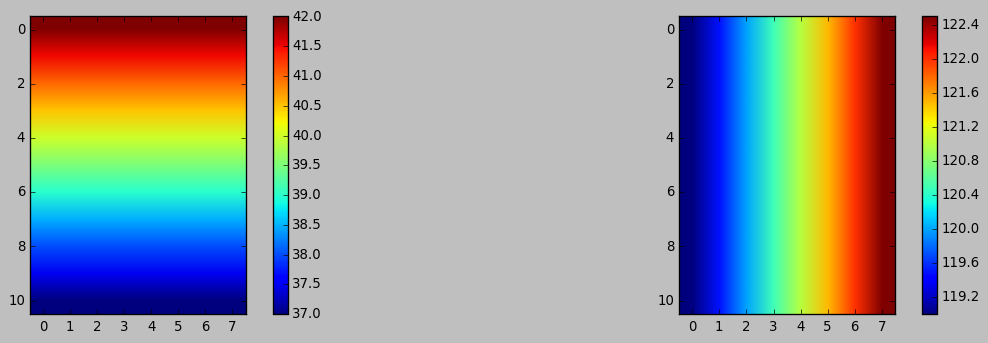

In [23]:
plt.close('all')
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.imshow(ncepGFSmodelWind['lats_wind'])
plt.jet()
plt.colorbar()
plt.subplot(122)
plt.imshow(ncepGFSmodelWind['lons_wind'])
plt.jet()
plt.colorbar()

# Reprojecting data

In [24]:
from pylab import *
import pyresample as pr
from pyproj import Proj

In [25]:
pr.kd_tree.which_kdtree()
pr.get_capabilities()

{'numexpr': True, 'pykdtree': True}

In [26]:
# Pixel resolution
import distancelib

# we use pxlResWind/pxlResSAR for further pyresample radius_of_influence and sigmas
pxlResWind = asarray(distancelib.getPixelResolution(ncepGFSmodelWind['lats_wind'], \
                                                    ncepGFSmodelWind['lons_wind'], \
                                                    ncepGFSmodelWind['lats_wind'].shape, 'km'))
pxlResSAR  = asarray(distancelib.getPixelResolution(lats_2, lons_2, lons_2.shape, 'km'))*1e3

# Note pxlResWind is in KM, multiply by 1e3 for meters
print "ASAR cell resolution, %s m"  % pxlResSAR
print "Wind cell resolution, %s km" % pxlResWind

ASAR cell resolution, [ 75.07189946  74.81915985] m
Wind cell resolution, [ 50.53147114  36.13624909] km


In [27]:
# reproject NCEP onto ASAR grid before calculations
# Try both BivariateSpline, griddata and pyresample

ncep_def  = pr.geometry.GridDefinition (lons=ncepGFSmodelWind['lons_wind'], \
                                        lats=ncepGFSmodelWind['lats_wind'])
swath_def = pr.geometry.SwathDefinition(lons=lons_2, lats=lats_2)


In [28]:
# wind_speed_model_swath = pr.kd_tree.resample_gauss(ncep_def, ncepGFSmodelWind['wind_speed'].ravel(), swath_def, \
#                                              radius_of_influence=2*pxlResWind.min()*1e3, neighbours=12, \
#                                              sigmas=pxlResWind.max()*1e3, fill_value=None, nprocs=numProcs)
wind_dir_model_swath   = pr.kd_tree.resample_gauss(ncep_def, ncepGFSmodelWind['wind_dir'].ravel(), swath_def, \
                                             radius_of_influence=2*pxlResWind.min()*1e3, neighbours=12, \
                                             sigmas=pxlResWind.max()*1e3, fill_value=None, nprocs=numProcs)

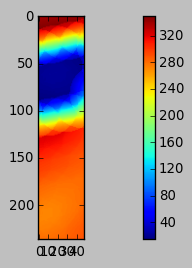

In [29]:
plt.close('all')
plt.figure(figsize=(16,3))
# plt.subplot(121)
# plt.imshow(wind_speed_model_swath[::scale,::scale])
# plt.jet()
# plt.colorbar()
# plt.subplot(122)
plt.imshow(wind_dir_model_swath[::scale,::scale])
plt.jet()
plt.colorbar()

In [30]:
# calculate bearing from initial lats/lons for further wind calculation
bearing = zeros((lons.shape[0]-1,lons.shape[1]))

for n in range(0,lons.shape[1]):
    col = ([lats[:-1,n], lons[:-1,n]], [lats[1:,n], lons[1:,n]])
    for m in range(0,lons.shape[0]-1):
        bearing[m][n] = distancelib.bearing(asarray(col[0])[:,m], asarray(col[1])[:,m])

# interpolate to raw_counts.shape
bearing_2 = imresize(bearing, raw_counts.shape)

In [31]:
# convert the signal measured in HH into VV polarization before using a GMF from the CMOD family
if pol == 'H/H':
    alpha=1 # for Sentinel Toolbox alpha=1, initially it was 0.6
    sigma0w = sigma0w*(1+2*tan(incident_angle*pi/180)**2)**2/(1+alpha*tan(incident_angle*pi/180)**2)**2

In [32]:
#NB! WINDDIR = 0 WHEN WIND BLOWS TOWARDS RADAR!
wind_dir_model_swath_rel = 90 + bearing_2 - wind_dir_model_swath

from cmod_gpu import rcs2windOpenCl
wind_speed_asar = rcs2windOpenCl(sar=sigma0w, windir=wind_dir_model_swath_rel, theta=incident_angle)

Execution time of CMOD5 with PyOpenCl: 0.801259 s
Mean wind speed: 2.49652133001 m/s


In [33]:
#NB! WINDDIR = 0 WHEN WIND BLOWS TOWARDS RADAR!
wind_dir_model_swath_rel = 90 + bearing_2 - wind_dir_model_swath
try:
    from cmod_gpu import rcs2windOpenCl
    wind_speed_asar = rcs2windOpenCl(sar=sigma0w, windir=wind_dir_model_swath_rel, theta=incident_angle)
except Exception:
    from cmod_vect import rcs2windPar
    wind_speed_asar = rcs2windPar(sigma0w, cmdv=5, windir=wind_dir_model_swath_rel, theta=incident_angle, nprocs=numProcs)

Execution time of CMOD5 with PyOpenCl: 0.788051 s
Mean wind speed: 2.49652133001 m/s


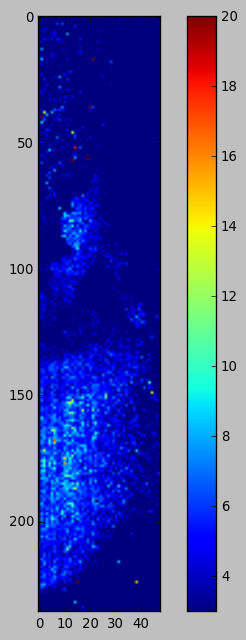

In [34]:
plt.close('all')
plt.figure(figsize=(16,8))
# plt.subplot(121)
# plt.imshow(wind_speed_model_swath[::scale,::scale], vmin=3, vmax=11)
# plt.jet()
# plt.colorbar()
plt.subplot(122)
plt.imshow(wind_speed_asar[::scale,::scale], vmin=3, vmax=20)
plt.jet()
plt.colorbar()

NameError: name 'lonlim' is not defined

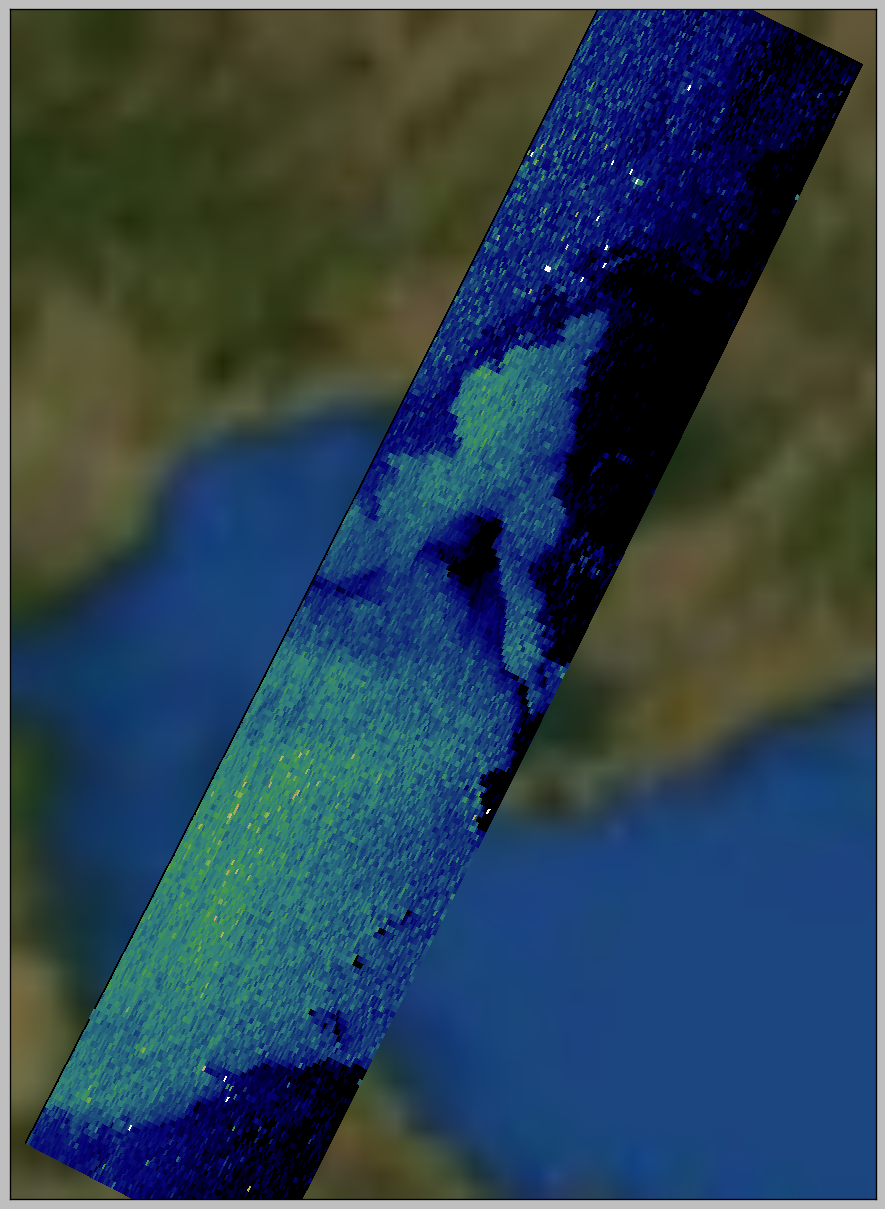

In [35]:
from mpl_toolkits.basemap import Basemap

plt.close('all')
plt.figure(figsize=(16,16))
lat_ts=70.0
lat_0=90.0
lon_0=-45

# width=7000000.
# height=7000000.
# m = Basemap(width=width,height=height,resolution='l',\
#             projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)

# Lat/Lon coords of image corners
ll_lat = lats_2.min()
ur_lat = lats_2.max()
ll_lon = lons_2.min()
ur_lon = lons_2.max()
cent_lat = lats_2.mean()
cent_lon = lons_2.mean()
m = Basemap(llcrnrlat=ll_lat, urcrnrlat=ur_lat,\
            llcrnrlon=ll_lon, urcrnrlon=ur_lon, \
            resolution='i', projection='stere', \
            lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)


m.bluemarble()

x,y=m(lons_2[::30,::10],lats_2[::30,::10])
CS=m.pcolormesh(x,y,wind_speed_asar[::30,::10],cmap=cm.gist_earth, vmin=0, vmax=20)#,ps,cmap=cm.jet,extend='max')

m.drawmeridians(np.arange(lonlim[0],lonlim[1],5),labels=[0,0,0,1],color='y')
m.drawparallels(np.arange(0,80,5),labels=[1,0,0,0],color='y')
m.drawcoastlines(linewidth=0.5,color='0.5')
plt.title('CMOD5.N Wind speed, [m/s]')

In [ ]:
# scale = 1
# ln = lons_2[::scale,::scale]
# lt = lats_2[::scale,::scale]
# data = roughness[::scale,::scale]

In [ ]:
def swath_area_def(name='Temporal SWATH EPSG Projection 4326', proj='eqc', lonlim=(-180,180), latlim=(-90,90), ellps="WGS84", res=111.2e3, lat_ts=None, lat_0=None, lon_0=None):
    """
    Convert given swath coordinates to pyresample area definition.
    The arguments are standard for Proj:
    name
    proj
    lonlim
    latlim
    ellipsoid
    resolution(meters)
    lat_ts (latitude of true scale)
    lat_0,lon_0 is central point
    EXAMPLE:
    
    epsg3426 is the default one
    for epsg3413:
    swath_area_def(name='Temporal SWATH EPSG Projection 3413', proj='stere', lonlim=(-180,180), latlim=(30,90), ellps="WGS84", res=111.2e3, lat_ts=70, lat_0=90, lon_0=-45)
        
    """

    area_id = name.replace(" ", "_").lower()
    proj_id = area_id

    up    = min(latlim)
    down  = max(latlim)
    left  = min(lonlim)
    right = max(lonlim)
    
    if proj == 'eqc':
        p = Proj(proj=proj, llcrnrlat=up, urcrnrlat=down, llcrnrlon=left, urcrnrlon=right, ellps=ellps)
        proj4_args = '+proj=' + str(proj) + ' ' + \
             '+llcrnrlat=' + str(up) + ' ' + \
             '+urcrnrlat=' + str(down) + ' ' + \
             '+llcrnrlon=' + str(left) + ' ' + \
             '+urcrnrlon=' + str(right) + ' ' + \
             '+ellps=' + str(ellps)
    elif lat_ts!=None and lat_0!=None:
        # lat_ts is latitude of true scale.
        # lon_0,lat_0 is central point.
        p = Proj(proj=proj, lat_0=lat_0, lon_0=lon_0, lat_ts=lat_ts, ellps=ellps)
        proj4_args = '+proj=' + str(proj) + ' ' + \
             '+lat_0=' + str(lat_0) + ' ' + \
             '+lon_0=' + str(lon_0) + ' ' + \
             '+lat_ts=' + str(lat_ts) + ' ' + \
             '+ellps=' + str(ellps)
    elif lon_0!=None and lat_0!=None and lat_ts==None:
        # lon_0,lat_0 is central point.
        p = Proj(proj=proj, lat_0=lat_0, lon_0=lon_0, ellps=ellps)
        proj4_args = '+proj=' + str(proj) + ' ' + \
             '+lat_0=' + str(lat_0) + ' ' + \
             '+lon_0=' + str(lon_0) + ' ' + \
             '+ellps=' + str(ellps)
    elif lon_0==None and lat_0==None and lat_ts==None:
        # lon_0,lat_0 is central point.
        lat_0 = (min(latlim) + max(latlim)) / 2
        lon_0 = (min(lonlim) + max(lonlim)) / 2
        p = Proj(proj=proj, lat_0=lat_0, lon_0=lon_0, ellps=ellps)
        proj4_args = '+proj=' + str(proj) + ' ' + \
             '+lat_0=' + str(lat_0) + ' ' + \
             '+lon_0=' + str(lon_0) + ' ' + \
             '+ellps=' + str(ellps)

    # area_extent defined as (x_min, y_min, x_max, y_max)
    left_ex1, up_ex1 = p(left, up)
    right_ex1, up_ex2 = p(right, up)
    left_ex2, down_ex1 = p(left, down)
    right_ex2, down_ex2 = p(right, down)

#     area_extent = (min(left_ex1, left_ex2),
#                    min(up_ex1, up_ex2),
#                    max(right_ex1, right_ex2),
#                    max(down_ex1, down_ex2))

    # минимум из всех координат X, Y, максимум из всех координат X, Y
    # Такой результат даёт правильный area_extent для 3413
    # При этом для 4326 area_extent остаётся неизменным
    # area_def_3413 = swath_area_def(name='Temporal SWATH EPSG Projection 3413', proj='stere', \
    #                                lonlim=(-180,180), latlim=(30,90), ellps="WGS84", res=1500, \
    #                                lat_ts=70, lat_0=90, lon_0=-45)
    # Area extent: (-5050747.263141337, 0.0, 0.0, 5050747.263141336)
    area_extent = (min(left_ex1, left_ex2, right_ex1, right_ex2),
                   min(up_ex1, up_ex2, down_ex1, down_ex2),
                   max(left_ex1, left_ex2, right_ex1, right_ex2),
                   max(up_ex1, up_ex2, down_ex1, down_ex2))

#     newCS = (p(min(lonlim),latlim[0]), \
#              p(min(lonlim),latlim[1]), \
#              p(max(lonlim),latlim[0]), \
#              p(max(lonlim),latlim[1]))
#     newCS = asarray(newCS)
#     area_extent = (max(newCS[:,0]), max(newCS[:,1]), min(newCS[:,0]),  min(newCS[:,1]))

#     area_extent = (min(newCS[:,0]), max(newCS[:,0]), min(newCS[:,1]),  max(newCS[:,1]))
#     area_extent = (min(newCS[:,0]), min(newCS[:,1]), max(newCS[:,0]), max(newCS[:,1]))
#     newCS = p(min(lonlim),max(latlim)), p(max(lonlim),min(latlim))
#     area_extent = (min(newCS[0]), max(newCS[0]), min(newCS[1]), max(newCS[1]))

#     Using abs() to avoid negative numbers of coloumns/rows as for epsg3413 for example
    xsize = abs(int((area_extent[2] - area_extent[0]) / res))
    ysize = abs(int((area_extent[3] - area_extent[1]) / res))

    swath_area_def = pr.utils.get_area_def(area_id, name, proj_id, proj4_args, xsize, ysize, area_extent)

    print swath_area_def

    return swath_area_def



In [ ]:
lonlim=(lons_2.min(),lons_2.max())
latlim=(lats_2.min(),lats_2.max())
print lonlim, latlim

# http://epsg.io/3413/map

In [ ]:
# 4326 lat/lon Area extent: (13306222.537383052, 4124755.141144392, 13587395.30854013, 4666106.128145058)
# 3413 lat/lon Area extent: (1473617.164248772, 5942067.021573546, 1380864.7441117594, 5384946.266147111)

# Area extent: (5839.8649434382805, 2216607.6224251273, -503728.2993214028, 1253240.2843227405)



p = Proj('+units=m +ellps=WGS84 +lon_0=-45 +proj=stere +lat_ts=70 +lat_0=90')
# oldCS = ((lons_2[0,0],lats_2[0,0]), \
#          (lons_2[-1,0],lats_2[-1,0]), \
#          (lons_2[0,-1],lats_2[0,-1]), \
#          (lons_2[-1,-1],lats_2[-1,-1]))
# newCS = (p(lons_2[0,0],lats_2[0,0]), \
#          p(lons_2[-1,0],lats_2[-1,0]), \
#          p(lons_2[0,-1],lats_2[0,-1]), \
#          p(lons_2[-1,-1],lats_2[-1,-1]))
oldCS = ((min(lonlim),min(latlim)), \
         (min(lonlim),max(latlim)), \
         (max(lonlim),min(latlim)), \
         (max(lonlim),max(latlim)))
# newCS = (p(min(lonlim),min(latlim)), \
#          p(min(lonlim),max(latlim)), \
#          p(max(lonlim),min(latlim)), \
#          p(max(lonlim),max(latlim)))
newCS = p(min(lonlim),max(latlim)), p(max(lonlim),min(latlim))
oldCS = asarray(oldCS)
newCS = asarray(newCS)

# area_extent = (min(newCS[:,0]), max(newCS[:,0]), min(newCS[:,1]),  max(newCS[:,1]))
# Area extent: (1644326.5606826267, 5942067.0215735463, 1237507.2185079353, 5384946.2661471106)
# area_extent = (newCS[0,0], newCS[0,1], newCS[-1,0], newCS[-1,1])
# Area extent: (1644326.5606826267, 5942067.0215735463, 1237507.2185079353, 5325178.1996833086)
# area_extent = (newCS[0,0], newCS[0,1], newCS[-1,0], newCS[1,1])
# Area extent: (1644326.5606826267, 6008758.8473417237, 1237507.2185079353, 5325178.1996833086)
# area_extent = (newCS[0,0], newCS[2,1], newCS[-1,0], newCS[1,1])
area_extent = (min(newCS[0]), min(newCS[1]), max(newCS[1]), max(newCS[0]))
print oldCS
print '\n'
print newCS
print '\n'
print area_extent


In [ ]:
from pyresample import utils
name = 'Temporal SWATH EPSG Projection 3413'
area_id = name.replace(" ", "_").lower()
proj_id = area_id
proj4_args = '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +ellps=WGS84 +datum=WGS84 +units=m'
x_size = 9000
y_size = 9000
area_extent = (-5050747.2631, 0.0000, 0.0000, 5050747.2631)
area_def = utils.get_area_def(area_id, name, proj_id, proj4_args, x_size, y_size, area_extent)
print area_def

In [ ]:
area_def_3413 = swath_area_def(name='Temporal SWATH EPSG Projection 3413', proj='stere',
                          lonlim=(-180,180), latlim=(30,90), ellps="WGS84", res=1500,
                          lat_ts=70, lat_0=90, lon_0=-45)

In [ ]:
# area_def = swath_area_def(name='Temporal SWATH EPSG Projection 3413', proj='stere', lonlim=(-180,180), latlim=(30,90), ellps="WGS84", res=111.2e3, lat_ts=70, lat_0=90, lon_0=-45)
# area_def = swath_area_def()

# area_def = swath_area_def(name='Temporal SWATH EPSG Projection 4326', proj='eqc',
#                           lonlim=(lon.min(),lon.max()), latlim=(lat.min(),lat.max()), ellps="WGS84", res=1500)

# area_def3413 = swath_area_def(name='Temporal SWATH EPSG Projection 3413', proj='stere',
#                           lonlim=(lons_2.min(),lons_2.max()), latlim=(lats_2.min(),lats_2.max()), ellps="WGS84", res=1500,
#                           lat_ts=70, lat_0=90, lon_0=-45)

area_def_4326 = swath_area_def(name='Temporal SWATH EPSG Projection 4326', proj='eqc',
                          lonlim=(lons_2.min(),lons_2.max()), latlim=(lats_2.min(),lats_2.max()), ellps="WGS84", res=1500)

# NB! multiproc and zmq doesn't work properly under IPython yet
# result = pr.kd_tree.resample_nearest(swath_def, data.ravel(), area_def, radius_of_influence=300, nprocs=numProcs)
# result = pr.kd_tree.resample_gauss(swath_def, data, area_def, radius_of_influence=500, sigmas=500, fill_value=None)
roughness_4326 = pr.kd_tree.resample_nearest(swath_def, roughness, area_def_4326, \
                                             radius_of_influence=4*pxlResSAR.max(), epsilon=0.5, fill_value=None)

# wind_speed_asar_4326 = pr.kd_tree.resample_nearest(swath_def, wind_speed_asar, area_def_4326, \
#                                                    radius_of_influence=4*pxlResSAR.max(), epsilon=0.5, fill_value=None)


In [ ]:
plt.close('all')
plt.figure(figsize=(16,4))
pr.plot.show_quicklook(area_def_4326, roughness_4326, vmin=0, vmax=2, \
                       label='Test', num_meridians=45, num_parallels=10, coast_res='i')

In [ ]:
lonlim=(lons_2.min(),lons_2.max())
latlim=(lats_2.min(),lats_2.max())
up    = min(latlim)
down  = max(latlim)
left  = min(lonlim)
right = max(lonlim)
# lat_0 = (up + down) / 2
# lon_0 = (right + left) / 2
lat_0=90
lon_0=(right + left) / 2

# Classical 3413 with Greenland centered
lat_0=90
lon_0=-45

area_def_3413 = swath_area_def(name='Temporal SWATH EPSG Projection 3413', proj='stere',
                          lonlim=(lons_2.min(),lons_2.max()), latlim=(lats_2.min(),lats_2.max()), ellps="WGS84", res=1500,
                          lat_ts=70, lat_0=lat_0, lon_0=lon_0)

roughness_3413 = pr.kd_tree.resample_nearest(swath_def, roughness, area_def_3413, \
                                             radius_of_influence=4*pxlResSAR.max(), epsilon=0.5, fill_value=None)

# wind_speed_asar_3413 = pr.kd_tree.resample_nearest(swath_def, wind_speed_asar, area_def_3413, \
#                                                    radius_of_influence=4*pxlResSAR.max(), epsilon=0.5, fill_value=None)


In [ ]:
!!!! expand area_def CENTERED ON GREENLAND !!!!!
# Classical 3413 with Greenland centered
lat_0=90
lon_0=-45

area_def_3413 = swath_area_def(name='Temporal SWATH EPSG Projection 3413', proj='stere',
                          lonlim=(lons_2.min()-25,lons_2.max()+35), latlim=(lats_2.min()-5,lats_2.max()+5), ellps="WGS84", res=1500,
                          lat_ts=70, lat_0=lat_0, lon_0=lon_0)

roughness_3413 = pr.kd_tree.resample_nearest(swath_def, roughness, area_def_3413, \
                                             radius_of_influence=4*pxlResSAR.max(), epsilon=0.5, fill_value=None)

plt.close('all')
plt.figure(figsize=(16,4))
pr.plot.show_quicklook(area_def_3413, roughness_3413, vmin=0, vmax=2, \
                       label='Test', num_meridians=10, num_parallels=5, coast_res='i')

In [ ]:
!!!! CENTERED ON IMAGE !!!!!

lonlim=(lons_2.min(),lons_2.max())
latlim=(lats_2.min(),lats_2.max())
up    = min(latlim)
down  = max(latlim)
left  = min(lonlim)
right = max(lonlim)
# lat_0 = (up + down) / 2
# lon_0 = (right + left) / 2
lat_0=90
lon_0=(right + left) / 2

area_def_3413 = swath_area_def(name='Temporal SWATH EPSG Projection 3413', proj='stere',
                          lonlim=(lons_2.min(),lons_2.max()), latlim=(lats_2.min(),lats_2.max()), ellps="WGS84", res=1500,
                          lat_ts=70, lat_0=lat_0, lon_0=lon_0)

roughness_3413 = pr.kd_tree.resample_nearest(swath_def, roughness, area_def_3413, \
                                             radius_of_influence=4*pxlResSAR.max(), epsilon=0.5, fill_value=None)

plt.close('all')
plt.figure(figsize=(16,4))
pr.plot.show_quicklook(area_def_3413, roughness_3413, vmin=0, vmax=2, \
                       label='Test', num_meridians=10, num_parallels=5, coast_res='i')

In [ ]:
!!!! CENTERED ON GREENLAND !!!!!

# Classical 3413 with Greenland centered
lat_0=90
lon_0=-45

area_def_3413 = swath_area_def(name='Temporal SWATH EPSG Projection 3413', proj='stere',
                          lonlim=(lons_2.min(),lons_2.max()), latlim=(lats_2.min(),lats_2.max()), ellps="WGS84", res=1500,
                          lat_ts=70, lat_0=lat_0, lon_0=lon_0)

roughness_3413 = pr.kd_tree.resample_nearest(swath_def, roughness, area_def_3413, \
                                             radius_of_influence=4*pxlResSAR.max(), epsilon=0.5, fill_value=None)

plt.close('all')
plt.figure(figsize=(16,4))
pr.plot.show_quicklook(area_def_3413, roughness_3413, vmin=0, vmax=2, \
                       label='Test', num_meridians=10, num_parallels=5, coast_res='i')

In [ ]:
from mpl_toolkits.basemap import Basemap

plt.close('all')
plt.figure(figsize=(16,16))
lat_ts=70.0
lat_0=90.0
lon_0=-45

# width=7000000.
# height=7000000.
# m = Basemap(width=width,height=height,resolution='l',\
#             projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)

# Lat/Lon coords of image corners
ll_lat = lats_2.min()
ur_lat = lats_2.max()
ll_lon = lons_2.min()
ur_lon = lons_2.max()
cent_lat = lats_2.mean()
cent_lon = lons_2.mean()
m = Basemap(llcrnrlat=ll_lat, urcrnrlat=ur_lat,\
            llcrnrlon=ll_lon, urcrnrlon=ur_lon, \
            resolution='i', projection='stere', \
            lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)


m.bluemarble()

x,y=m(lons_2[::30,::10],lats_2[::30,::10])
CS=m.pcolormesh(x,y,roughness[::30,::10],cmap=cm.gist_earth, vmin=0, vmax=2)#,ps,cmap=cm.jet,extend='max')

m.drawmeridians(np.arange(lonlim[0],lonlim[1],5),labels=[0,0,0,1],color='y')
m.drawparallels(np.arange(0,80,5),labels=[1,0,0,0],color='y')
m.drawcoastlines(linewidth=0.5,color='0.5')
plt.title('test EPSG=3413')

# Apply Mask from GSHHS

In [ ]:
import gshhs_rasterize
reload(gshhs_rasterize)

In [ ]:
import os, re

def purgeFile(dir, pattern):
    for f in os.listdir(dir):
        if re.search(pattern, f):
            os.remove(os.path.join(dir, f))


In [ ]:
# ESRI shapefile containing land polygons
shapefile = '/media/SOLabNFS/store/auxdata/coastline/GSHHS_shp/f/GSHHS_f_L1.shp'

# purge other projections if exist
purgeFile(shapefile[:-14], 'GSHHS_f_L1_')


In [ ]:

# lonlim = (lons_2.min(),lons_2.max())
# latlim = (lats_2.min(),lats_2.max())

# lonlim = (100,130)
# latlim = (30,50)

raster_shape = roughness_3413.shape
proj = '+units=m +ellps=WGS84 +lon_0=-45 +proj=stere +lat_ts=70 +lat_0=90'
proj = '+units=m +ellps=WGS84 +lon_0=' + str(lon_0) +' +proj=stere +lat_ts=70 +lat_0=90'
proj_name = '3413'
lakes = True

mask_arr_3413 = gshhs_rasterize.gshhs_rasterize(lonlim, latlim, 'm', \
                    raster_shape, proj, proj_name, lakes, \
                    shapefile)

raster_shape = roughness_4326.shape
proj = '4326'
proj_name=None

mask_arr_4326 = gshhs_rasterize.gshhs_rasterize(lonlim, latlim, 'deg', \
                    raster_shape, proj, proj_name, lakes, \
                    shapefile)


plt.close('all')
plt.figure(figsize=(16,8))
plt.subplot(141)
plt.imshow(mask_arr_3413)
plt.subplot(142)
plt.imshow(mask_arr_4326)
plt.subplot(143)
plt.imshow(roughness_3413, vmin=0, vmax=2)
plt.subplot(144)
plt.imshow(roughness_4326, vmin=0, vmax=2)

In [ ]:
roughness_4326_masked = ma.masked_where(mask_arr_4326, roughness_4326)
# wind_speed_asar_4326_masked = ma.masked_where(mask_arr_4326, wind_speed_asar_4326)

roughness_3413_masked = ma.masked_where(mask_arr_3413, roughness_3413)
# wind_speed_asar_3413_masked = ma.masked_where(mask_arr_3413, wind_speed_asar_3413)

In [ ]:
close("all")
plt.figure(figsize=(8,8))
pr.plot.show_quicklook(area_def_4326, roughness_4326_masked, vmin=0, vmax=2, \
                       label='Test', num_meridians=45, num_parallels=10, coast_res='i')

In [ ]:
close("all")
plt.figure(figsize=(8,8))
pr.plot.show_quicklook(area_def_4326, wind_speed_asar_4326_masked, vmin=3, vmax=13, \
                       label='Test', num_meridians=45, num_parallels=10, coast_res='i')

In [ ]:
close("all")
plt.figure(figsize=(8,8*double(roughness_3413.shape[0])/double(roughness_3413.shape[1])))
pr.plot.show_quicklook(area_def_3413, roughness_3413_masked, vmin=0, vmax=2, \
                       label='Test', num_meridians=45, num_parallels=10, coast_res='i')

In [ ]:
close("all")
plt.figure(figsize=(8,8*double(roughness_3413.shape[0])/double(roughness_3413.shape[1])))
pr.plot.show_quicklook(area_def_3413, wind_speed_asar_3413_masked, vmin=3, vmax=13, \
                       label='Test', num_meridians=45, num_parallels=10, coast_res='i')

In [ ]:
oFileName

In [ ]:
# Save png image and kml file

import simplekml

def create_KML_asar(area_extent, savepath):
    kml = simplekml.Kml()

    pol = kml.newpolygon(name='area_extent', visibility=1)
    pol.tessellate = 1

    pol.altitudemode = 'clampToGround'
    pol.outerboundaryis.coords = [(area_extent[0], area_extent[1]), (area_extent[2], area_extent[3])]
    if type(savepath) == list:
        for _savepath in savepath:
            kml.save(_savepath)
    else:
        kml.save(savepath)

oPath = '/media/SOLabNFS2/http/tiles/ASAR_sigma0/sigma0/tmp/'
oFileName = os.path.join(oPath, fileName+'.png')

close('all')
gray()
imsave(oFileName, roughness_3413_masked, vmin=0, vmax=2)
# create_KML_asar(area_def.area_extent, os.path.join(oPath, fileName+'.kml'))

In [ ]:
# Generate tiles

import gdal
import sys
sys.path.append('/usr/bin')
from gdal2tiles import GDAL2Tiles

def create_asar_tiles(png_filename, tiles_output_dir, proj):
    local_argv = ['/usr/bin/gdal2tiles.py', '-p', 'raster', '-r', 'cubic',
                  '-s', proj, png_filename, tiles_output_dir]
    argv = gdal.GeneralCmdLineProcessor(local_argv)
    if argv:
        gdal2tiles = GDAL2Tiles(argv[1:])
        gdal2tiles.process()

create_KML_asar(area_def.area_extent, os.path.join(oPath, fileName+'.kml'))

tiles_3413_output_dir = os.path.join(oPath, 'tiles')
png_3413_filename = oFileName
create_asar_tiles(png_3413_filename, tiles_3413_output_dir, 'EPSG:3413')